In [1]:
############### lib and device-agnostic code  #############

import torch
from torch import nn

torch.__version__

'2.5.0'

In [2]:
########## setup-device ############

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
############ get data ###########

import requests
import zipfile
from pathlib import Path

data_path = Path("./data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} dir exists")

else:
    print(" Did not find {image_path} dir, creating one ...")
    image_path.mkdir(parents= True, exist_ok= True)

    # Downloading pizza, steak, sushi data
    with open(data_path / 'pizza_steak_sushi.zip', "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading data .... ")
        f.write(request.content)

    # unzip 
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip" , "r") as zip_ref:
        print("extracting zip ..........")
        zip_ref.extractall(image_path)

data\pizza_steak_sushi dir exists


In [4]:
########### data prep #############

import os 

def walk_through_dir(dir_path:str):
    ''' 
    args:
        dir_path (str) - path for the image data

    return:
        print out 
            num of sub dir
            num of img in each sub dir
            name of each sub dir 
    '''

    for root, dir, files in os.walk(dir_path):
        print(f" there are {len(dir)} directories and {len(files)} images in '{root}'.")

In [5]:
walk_through_dir(image_path)

 there are 2 directories and 0 images in 'data\pizza_steak_sushi'.
 there are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
 there are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
 there are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
 there are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
 there are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
 there are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
 there are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
 there are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [6]:
train_dir = image_path / "train"
test_dir = image_path / 'train'

train_dir, test_dir 

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/train'))

 random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


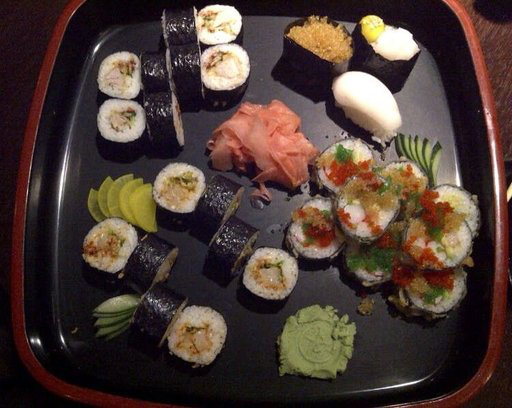

In [7]:
################ visualize the data #############

import random 
from PIL import Image

random.seed(42)

########### Get all image path 
image_path_list = list(image_path.glob("*/*/*.jpg"))

######## get random image path ###########
random_image_path = random.choice(image_path_list)

######### get image class name from path name ( where class name is the name od the dir where image is stored ) ############
image_class = random_image_path.parent.stem

####### open image ###########
img = Image.open(random_image_path)

####### print metadata ############
print(f" random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

(np.float64(-0.5), np.float64(511.5), np.float64(407.5), np.float64(-0.5))

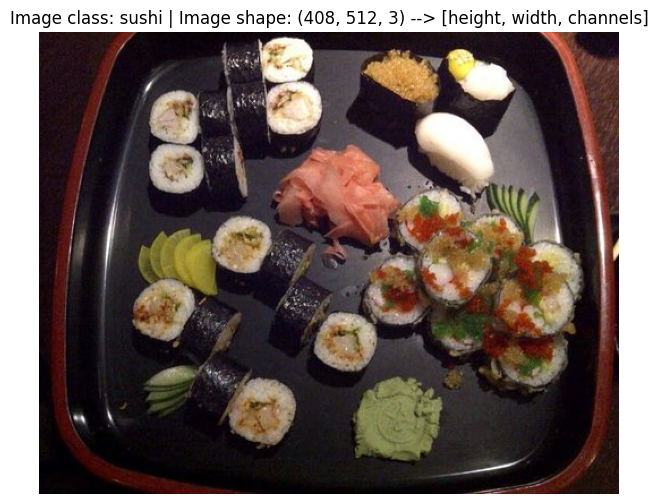

In [8]:
####### same with matplotlib ##########

import matplotlib.pyplot as plt 
import numpy as np

img_as_array = np.array(img)

plt.figure(figsize= (10, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} --> [height, width, channels]")
plt.axis(False)

In [9]:
########### data transformation ############

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder

In [10]:
##### tranformation code #####

data_transform = v2.Compose([
    v2.Resize(size = (64, 64)),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.ToTensor() #### 0 - 255 ---> 0 - 1
])

d:\miniconda3\envs\nn\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


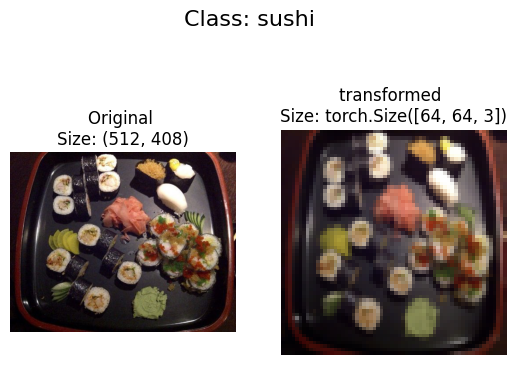

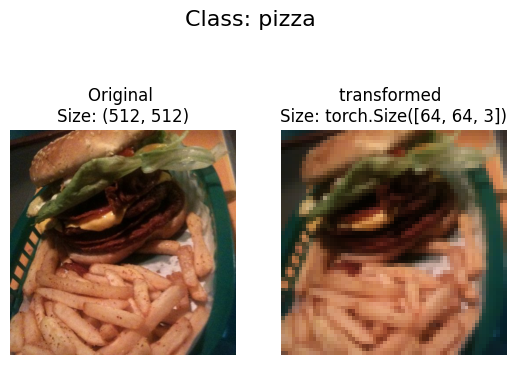

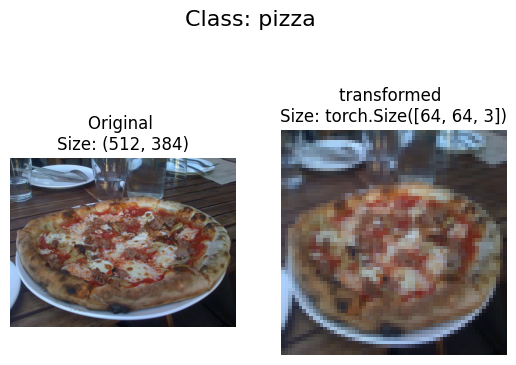

In [11]:
######## visualize with various images ###########

def plot_transformed_images(image_paths, transform, n=3, seed = 42):

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k= n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            ##### transformed ###########
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

plot_transformed_images(image_path_list,
                        transform = data_transform, 
                        n = 3)


In [12]:
######### Loading Image Data using Image Folder ######### 
####### option -1 ###########

train_data = ImageFolder(
    root = train_dir,
    transform= data_transform,  ####### transform perform on images
    target_transform= None  ############ transformer perform on labels
)

test_data = ImageFolder(
    root = test_dir,
    transform= data_transform
)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
                 Resize(size=[64, 64], interpolation=InterpolationMode.BILINEAR, antialias=True)
                 RandomHorizontalFlip(p=0.5)
                 ToTensor()
           )


In [13]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
####### class name get in dict ##########
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image data type: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image Tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


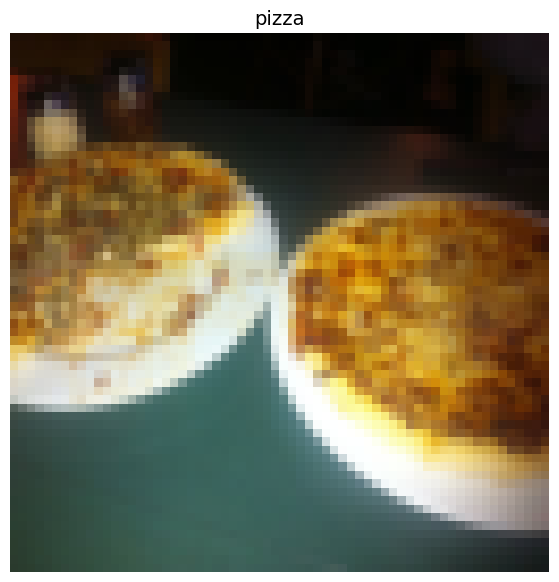

In [16]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [17]:
# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=16, # how many samples per batch?
                              num_workers=4, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=4, 
                             num_workers=4, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2c5128ebc80>,
 <torch.utils.data.dataloader.DataLoader at 0x2c5128eb950>)

In [18]:
img, label = next(iter(train_dataloader))

# Batch size will now be 16, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([16, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


In [22]:
########## option- 2 ##############
""" 
what if a pre-built Dataset creater doesn;t exist ?
or 
one for our specific problem doesn't exist ?
"""
############# Loading Image Data with Custom Dataset #############

from typing import Tuple, Dict, List

In [23]:
# Remember 
# Instance of torchvision.datasets.ImageFolder()
# thi is what we are going to replicate 

train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [24]:
################### creating a helper function to get the class names ############

target_dir = train_dir
print(f"Target directory: {train_dir}")

# get the class names
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path /"train"))])
print(f"class names found: {class_names_found}")

Target directory: data\pizza_steak_sushi\train
class names found: ['pizza', 'steak', 'sushi']


In [25]:
# Make a func to find classes in target dir 

def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:

    # 1. get a class name by scanning the target dir 
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found 
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
    
    # 3. Create a dict of index labels (computers prefers numbers rather than string labels)

    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

In [27]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [28]:
################ Create a custom dataset to replicate a ImageFolder() ############

# write a custom dataset class (inherits from torch.utils.data.Dataset)

# 1. subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with the target_dir and transform (optional) parameter
    def __init__(self, target_dir:str, transform = None) -> None:

        # 3. Create class attributes
        # Get all image path
        self.path = list(Path(target_dir).glob('*/*.jpg'))

        # setup transforms
        self.transform = transform

        # create classes and class_to_idx attributes 
        self.classes, self.class_to_idx = find_classes(target_dir)

    # 4. Make function to load images 
    def load_images(self, index:int) -> Image.Image:
        'Opens an image via a path and returns it '
        image_path = self.path[index]

        return Image.open(image_path)
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total num of samples"
        return len(self.path)
    
    # 6. Overwrite the __getitem__() method (required)
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)"

        img = self.load_images(index)
        class_name = self.path[index].parent.name 
        class_idx = self.class_to_idx[class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [29]:
# Augment the train train data 
train_transform = v2.Compose([
    v2.Resize((64, 64)),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.ToTensor()
])

# Not Augment th test data 
test_transform = v2.Compose([
    v2.Resize((64,64)),
    v2.ToTensor()
])

d:\miniconda3\envs\nn\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [30]:
train_data_custom = ImageFolderCustom(target_dir= train_dir, 
                                      transform= train_transform)

test_data_custom = ImageFolderCustom(target_dir= test_dir,
                                     transform= test_transform)

In [31]:
len(train_data_custom), len(test_data_custom)

(225, 225)

In [32]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [33]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [34]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


In [36]:
############# create a function to dispplay a random images ##################

# 1. Take a Dataset as well as a list of class name 
def display_random_images(dataset:Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2.Adjust isplay  if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
        
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. get random sample indexes
    random_sample_idx = random.sample(range(len(dataset)), k = n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_sample_idx):
        targ_img, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting [N,H,W] -> [H,W,N]
        targ_img_adjust = targ_img.permute(1,2,0)

        # plot the adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_img_adjust)
        plt.axis("off")
        if classes:
            title = f'class: {classes[targ_label]}'

            if display_shape:
                title = title + f'\nshape: {targ_img_adjust.shape}'
        
        plt.title(title)


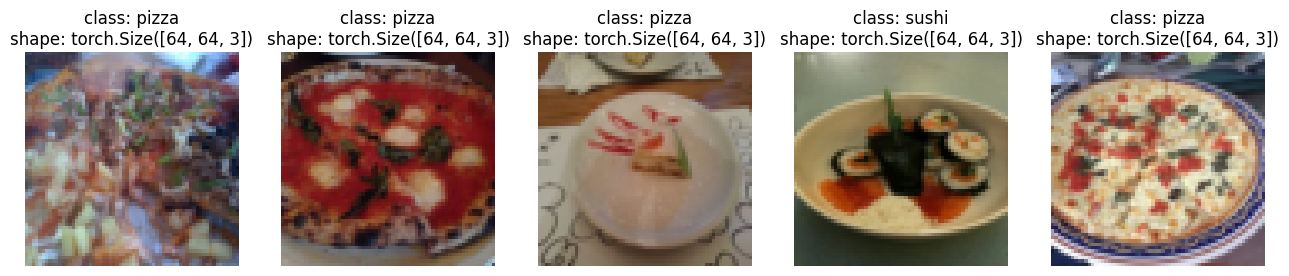

In [37]:
display_random_images(
    train_data,
    n =5,
    classes= class_names,
    seed = None
)

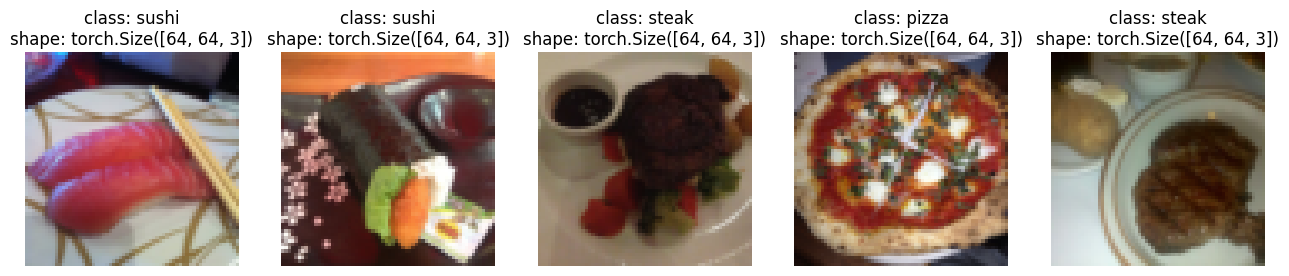

In [38]:
display_random_images(
    train_data_custom,
    n = 5, 
    classes= class_names,
    seed= None
)

In [45]:
########### Turn custom images into DataLoader's #############

train_dataloader_custom = DataLoader(
    dataset= train_data_custom,
    batch_size= 16,
    num_workers= 0,
    shuffle = True
)

test_dataloader_custom = DataLoader(
    dataset= test_data_custom,
    batch_size= 4,
    num_workers= 0, 
    shuffle= False
)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x2c512987050>,
 <torch.utils.data.dataloader.DataLoader at 0x2c51283e630>)

In [46]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([16, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


In [ ]:
############# create a Training Loop ###########

